In [1]:
import numpy as np
import os
import matplotlib.pyplot as plt
import h5py
from neuron import h
import plot_helper as ph

import scipy.stats as stat
from tqdm import tqdm
import operator
import math

#from scalebary import add_scalebar
from IPython.display import set_matplotlib_formats
set_matplotlib_formats('svg')

/var/folders/51/n2d2np955x1_s1f0242lh65r0000gn/T/ipykernel_81743/68747331.py:15: DeprecationWarning: `set_matplotlib_formats` is deprecated since IPython 7.23, directly use `matplotlib_inline.backend_inline.set_matplotlib_formats()`
  set_matplotlib_formats('svg')


In [2]:
my_dpi = 96

plt.rcParams['axes.spines.right'] = False
plt.rcParams['axes.spines.top'] = False
plt.rcParams['font.sans-serif'] = "Arial"
plt.rcParams['font.family'] = "sans-serif"
plt.rcParams['pdf.fonttype'] = 42
plt.rcParams['ps.fonttype'] = 42

tick_major = 3
tick_minor = 0
plt.rcParams["xtick.major.size"] = tick_major
plt.rcParams["xtick.minor.size"] = tick_minor
plt.rcParams["ytick.major.size"] = tick_major
plt.rcParams["ytick.minor.size"] = tick_minor

font_small = 12
font_medium = 13
font_large = 14
plt.rc('font', size=font_small)          # controls default text sizes
plt.rc('axes', titlesize=font_medium)    # fontsize of the axes title
plt.rc('axes', labelsize=font_medium)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=font_small)    # fontsize of the tick labels
plt.rc('ytick', labelsize=font_small)    # fontsize of the tick labels
plt.rc('legend', fontsize=font_small)    # legend fontsize
plt.rc('figure', titlesize=font_large)   # fontsize of the figure title

In [63]:
def cm_to_in(cm):
    return cm/2.54

def plot_comb_scores(opt_path, score_path, title, plot_save_path=None):
    opt_result = h5py.File(opt_path)
    #print(opt_result.keys())
    ordered_score_function_list = [e.decode('ascii') for e in opt_result['ordered_score_function_list'][:]]
    optimization_stim_names = [e.decode('ascii') for e in opt_result['opt_stim_name_list'][:]]
    optimization_weightes = opt_result['opt_weight_list'][:]
    best_stims_score_list = []
    for score_name in optimization_stim_names:
        curr_score_data = h5py.File(score_path+score_name+'_scores.hdf5', 'r')
        for sf in ordered_score_function_list:
            curr_stim_sf_pair = curr_score_data['norm_pin_scores_'+sf][:]
            best_stims_score_list.append(curr_stim_sf_pair)
    combined_score = sum([best_stims_score_list[i]*optimization_weightes[i] for i in range(len(optimization_weightes))])
    
    fig = plt.figure(figsize=(cm_to_in(7.5), cm_to_in(7.5)))
    ax = plt.gca()
    #plt.title(title)
    ax.set_xlabel('Rank')
    #ax.set_ylabel('Weighted Score')
    #ymax = np.max(combined_score)
    #plt.ylim([0,ymax])
    #plt.xlim([0,10000])
    
    ax.locator_params(axis='x', nbins=1)
    ax.get_yaxis().set_visible(False)
    #plt.locator_params(axis='y', nbins=3)
    time_step = range(len(combined_score))
    print('Spearman:', compute_spearman(combined_score))
    plt.scatter(time_step, combined_score, s=5, color='black', alpha=0.2, label=r'$\rho$='+str(compute_spearman(combined_score))[:6])
    plt.legend(loc='upper right', bbox_to_anchor=(1.8, 1))
    if plot_save_path:
        plt.savefig(plot_save_path+'.pdf', format='pdf', dpi=1000, bbox_inches="tight")

def plot_comb_scores_full(ordered_score_function_list, optimization_stim_names, optimization_weightes,\
                          score_path, title, plot_save_path=None):
    best_stims_score_list = []
    for score_name in optimization_stim_names:
        curr_score_data = h5py.File(score_path+score_name+'_scores.hdf5', 'r')
        for sf in ordered_score_function_list:
            curr_stim_sf_pair = curr_score_data['norm_pin_scores_'+sf][:]
            best_stims_score_list.append(curr_stim_sf_pair)
    combined_score = sum([best_stims_score_list[i]*optimization_weightes[i] for i in range(len(optimization_weightes))])
    
    fig = plt.figure(figsize=(cm_to_in(7.5), cm_to_in(7.5)))
    ax = plt.gca()
    #plt.title(title)
    ax.set_xlabel('Rank')
    #ax.set_ylabel('Weighted Score')
    #ymax = np.max(combined_score)
    #plt.ylim([0,ymax])
    #plt.xlim([0,10000])
    
    ax.locator_params(axis='x', nbins=1)
    ax.get_yaxis().set_visible(False)
    #plt.locator_params(axis='y', nbins=3)
    time_step = range(len(combined_score))
    plt.scatter(time_step, combined_score, s=5, color='black', alpha=0.2, label=r'$\rho$='+str(compute_spearman(combined_score))[:6])
    plt.legend(loc='upper right', bbox_to_anchor=(1.8, 1))
    print('Spearman:', compute_spearman(combined_score))
    if plot_save_path:
        plt.savefig(plot_save_path+'.pdf', format='pdf', dpi=1000, bbox_inches="tight")

def compute_spearman(scores):
    perfect_distribution = np.cumsum(np.ones(len(scores)))
    spearman = stat.spearmanr(scores, perfect_distribution)[0]
    if math.isnan(spearman):
        spearman = 0
    return spearman

def compute_best_pair(scores_path):
    score_names = os.listdir(scores_path)
    spearman_dict = {}
    for score_name in tqdm(score_names):
        scores = h5py.File(scores_path+score_name)
        stim_name = score_name.replace('_scores.hdf5', '')
        sf_names = sorted([e for e in list(scores.keys()) if 'norm_pin_scores_' in e])
        for sf_name in sf_names:
            spearman_val = compute_spearman(scores[sf_name][:])
            spearman_dict[(stim_name, sf_name.replace('norm_pin_scores_', ''))] = spearman_val
    best_pair = max(spearman_dict.items(), key=operator.itemgetter(1))[0]
    best_value = spearman_dict[best_pair]
    return best_pair, best_value

def compute_specific_pair(scores_path,stim,sf):
    score_names = os.listdir(scores_path)
    stim_name = f'{scores_path}{stim}_scores.hdf5'
    #h5py.File(scores_path+score_name)
    stim_score_names = h5py.File(stim_name)
    #sf_names = sorted([e for e in list(stim_score_names.keys()) if 'norm_pin_scores_' in e])
    #print(stim_score_names.keys())
    sf_name = f'norm_pin_scores_{sf}'
    spearman_val = compute_spearman(stim_score_names[sf_name][:])
    return [stim,sf],spearman_val

def plot_scores_best_pair(best_pair, score_path, title, plot_save_path=None):
    scores = h5py.File(scores_path+best_pair[0]+'_scores.hdf5')['norm_pin_scores_'+best_pair[1]][:]
    
    fig = plt.figure(figsize=(cm_to_in(7.5), cm_to_in(7.5)))
    ax = plt.gca()
    #plt.title(title)
    ax.set_xlabel('Rank')
    #ax.set_ylabel('Weighted Score')
    #ymax = np.max(combined_score)
    #plt.ylim([0,ymax])
    #plt.xlim([0,10000])
    
    ax.locator_params(axis='x', nbins=1)
    ax.get_yaxis().set_visible(False)
    #plt.locator_params(axis='y', nbins=3)
    time_step = range(len(scores))
    plt.scatter(time_step, scores, s=5, color='black', alpha=0.2, label=r'$\rho$='+str(compute_spearman(scores))[:6])
    plt.legend(loc='upper right', bbox_to_anchor=(1.8, 1))
    if plot_save_path:
        plt.savefig(plot_save_path+'.pdf', format='pdf', dpi=1000, bbox_inches="tight")

In [35]:
# for e in h5py.File(scores_path+os.listdir(scores_path)[0], 'r').keys():
#     if 'norm_' in e:
#         print(e)

# Best Pair

Random pair
Stim: he_3_15_5
Score function: chi_square_normal
Spearman: 0.5817939961864197


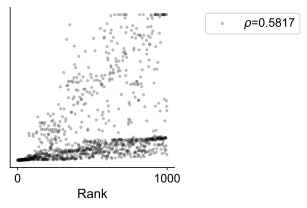

In [68]:
scores_path = './scores_1000/'
#stim_to_plot = 'chirp_f_0_to_0.18_a_3_to_9'
stim_to_plot = 'he_3_15_5'
sf = 'chi_square_normal'
#stim_to_plot = 'he_3_15_5'
pair_to_plot,_spearman_val = compute_specific_pair(scores_path,stim_to_plot,sf)
toy_model_plot_path = f'./plots/spearman_{stim_to_plot}_{sf}'
print('Random pair')
print('Stim:', stim_to_plot)
print('Score function:', sf)
print('Spearman:', _spearman_val)
plot_scores_best_pair(pair_to_plot, scores_path, f'{stim_to_plot}_{sf}', toy_model_plot_path)

In [9]:
scores_path = './scores_1000/'
best_pair, best_value = compute_best_pair(scores_path)

  0%|                                                                                       | 0/303 [00:00<?, ?it/s]/Users/kyunggeunkim/opt/anaconda3/lib/python3.9/site-packages/scipy/stats/stats.py:4484: SpearmanRConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(SpearmanRConstantInputWarning())
100%|█████████████████████████████████████████████████████████████████████████████| 303/303 [00:42<00:00,  7.21it/s]


Best pair
Stim: chirp_f_0.12_to_0_a_9_to_9
Score function: AP_amplitude
Spearman: 0.8521200778027024


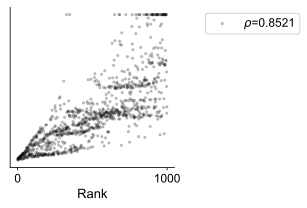

In [72]:
toy_model_best_pair_plot_path = './plots/scores_best_pair'
print('Best pair')
print('Stim:', best_pair[0])
print('Score function:', best_pair[1])
print('Spearman:', best_value)
plot_scores_best_pair(best_pair, scores_path, 'HH Best Pair', toy_model_best_pair_plot_path)

# Single-stim (Best)

Single stim
Spearman: 0.9467261747261748
Stims used to train: chirp_f_0.14_to_0_a_9_to_3


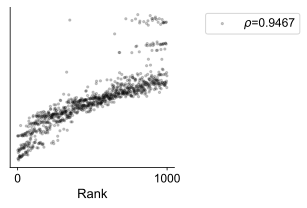

In [73]:
toy_model_plot_path = './plots/single_stim_combined_'
toy_model_opt_path_single = './analyze_p/optimization_results_path/opt_result_single_stim_hh_full_1000.hdf5'
toy_model_opt_path_multi = './analyze_p/optimization_results_path/multi_stim_hh_full_20_stims_1000.hdf5'
toy_model_score_path = './scores_1000/'
toy_model_multiple_stim_opt_file = h5py.File(toy_model_opt_path_multi, 'r')
ordered_score_function_list = [e.decode('ascii') for e in toy_model_multiple_stim_opt_file['ordered_score_function_list'][:]]
opt_file_single_stim = h5py.File(toy_model_opt_path_single, 'r')
train_stim_name_single_stim = opt_file_single_stim['stims_optimal_order'][0].decode('ascii')
#train_stim_name_single_stim = 'he_3_15_5'
#train_stim_name_single_stim = 'chirp_f_0_to_0.18_a_3_to_9'
optimal_weight_list_single_stim = opt_file_single_stim[train_stim_name_single_stim][:]
print('Single stim')
plot_comb_scores_full(ordered_score_function_list, [train_stim_name_single_stim],\
                      optimal_weight_list_single_stim, toy_model_score_path, 'HH Single Stimulus', \
                      toy_model_plot_path+'_best_'+train_stim_name_single_stim)
print('Stims used to train:', train_stim_name_single_stim)


In [8]:
#single Stim Chosen
print(toy_model_multiple_stim_opt_file.keys())

<KeysViewHDF5 ['opt_stim_name_list', 'opt_weight_list', 'ordered_score_function_list']>


# Multi-Stim


Multistims
Spearman: 0.9660857340857342


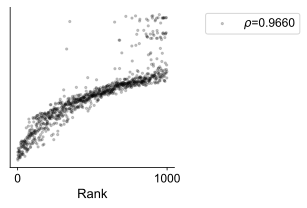

In [71]:
toy_model_opt_path = './analyze_p/optimization_results_path/multi_stim_hh_full_20_stims_1000.hdf5'
toy_model_score_path = './scores_1000/'
toy_model_plot_path = './plots/multi_stim_scores'
print('Multistims')
plot_comb_scores(toy_model_opt_path, toy_model_score_path, 'HH Full', toy_model_plot_path)
#print('Stims used to train:')
train_stim_names_full = h5py.File(toy_model_opt_path, 'r')['opt_stim_name_list'][:]
# for e in train_stim_names_full:
#     print(e.decode('ascii'))
